In [15]:
import autograd.numpy as np
import matplotlib.pyplot as plt

import wecopttool as wot

In [2]:
unstructured = False  # controller
electrical = True  # power

In [3]:
file = "./bem.nc"
data = wot.read_netcdf(file)
f1 = 0.05
nfreq = 50

In [4]:
amplitude = 0.0625 
idx = 6  # 0.3 Hz
freq = idx*f1
waves = wot.waves.regular_wave(f1, nfreq, freq, amplitude)

In [5]:
ndof_pto = 1
pto_names = ["PTO_Heave"]
kinematics_mat = np.eye(ndof_pto)

# controller
if unstructured:
    ncomponents_pto = 2*nfreq + 1
    controller = wot.pto.controller_unstructured
else:
    ncomponents_pto = 2
    controller = wot.pto.controller_pi

# PTO impedance - frequency dependent
omega = data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# PTO
pto = wot.pto.PTO(ndof_pto, kinematics_mat, controller, pto_impedance, None, pto_names)

In [6]:
data = wot.add_zerofreq_to_xr(data)
wec = wot.WEC.from_bem(data, f_add={'PTO': pto.force_on_wec})

Linear damping for DOF "HEAVE" has negative or close to zero terms. Shifting up via linear friction of 36.667232716402985 N/(m/s).


In [7]:
scale_x_wec = 1.0
scale_x_opt = 0.01 if ((not unstructured) and electrical) else 1.0
scale_obj = 1.0
if electrical:
    obj_fun = pto.average_power
else:
    obj_fun = pto.mechanical_average_power
res = wec.solve(waves, obj_fun, pto.ndof*ncomponents_pto,
                scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.944593181921505
            Iterations: 64
            Function evaluations: 82
            Gradient evaluations: 64


In [8]:
exc_coeff = data['Froude_Krylov_force'] + data['diffraction_force']
Fe = wot.wave_excitation(exc_coeff, waves)
w = data.coords['omega'].values[1:]
m = data['mass'].values
A = data['added_mass'].values[0, 0, 1:]
B = data['radiation_damping'].values[0, 0, 1:]
K = data['hydrostatic_stiffness'].values
Zi = ((1j*w)*(m + A)
        + B
        + (1/(1j*w)) * data['hydrostatic_stiffness'].values
        + 36.667232716402985)
Fe = np.reshape(Fe, -1)[1:]
Zi = np.reshape(Zi, -1)

if electrical:
    Z_11 = pto_impedance[0, 0, :]
    Z_12 = pto_impedance[0, 1, :]
    Z_21 = pto_impedance[1, 0, :]
    Z_22 = pto_impedance[1, 1, :]

    V_th = Z_21 / (Z_11 - Zi) * Fe
    Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Zi)

    cc_current_fd = V_th / (2*Z_th.real)
    cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd
    cc_voltage_td = wec.fd_to_td(np.concatenate([[0.0], cc_voltage_fd]))
    cc_current_td = wec.fd_to_td(np.concatenate([[0.0], cc_current_fd]))
    cc_power_td = cc_voltage_td * cc_current_td
    power_theoretical = -np.sum(cc_power_td) * wec.dt/wec.tf
else:
    Fe = Fe[idx-1]
    Zi = Zi[idx-1]
    power_theoretical = (np.abs(Fe)**2 / (8 * Zi.real))

power = -res.fun
power, power_theoretical

(28.944593181921505, 28.944593181811534)

In [9]:
if not unstructured:
    xopt = res.x[-pto.ndof*ncomponents_pto:]
    if electrical:
        optimal_gains_expected = "TODO, "
    else:
        omega_wave = waves.omega[idx].data.item()
        m = data['mass'] 
        w = data['omega']
        A = data['added_mass']
        B = data['radiation_damping']
        K = data['hydrostatic_stiffness']
        Bf = 36.667232716402985
        Zi = 1j*w*(A+m) + B+Bf + 1/(1j*w)*K
        Zic = Zi[idx].conj().data.item()
        optimal_gains_expected = -1*Zic.real + 1j * omega_wave * Zic.imag
    optimal_gains = xopt[0] + 1j*xopt[1]
    print(optimal_gains_expected, optimal_gains)

TODO,  (-4406.581870035993+8890.768144912758j)


In [33]:
x_wec, x_opt = wec.decompose_state(res.x)
pos = wec.vec_to_dofmat(x_wec)
vel = wec.derivative_mat @ pos 
acc = wec.derivative_mat @ vel

pos_fd = wot.real_to_complex(pos)
vel_fd = wot.real_to_complex(vel)
acc_fd = wot.real_to_complex(acc)

pos_td = wec.time_mat @ pos
vel_td = wec.time_mat @ vel
acc_td = wec.time_mat @ acc

/Users/cmichel/WecOptTool/.venv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


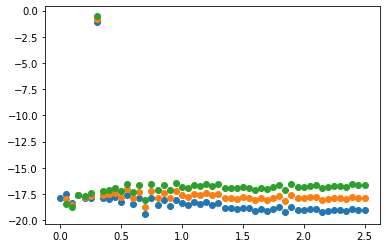

In [36]:
plt.figure()
plt.plot(wec.frequency, np.log10(np.abs(pos_fd)), 'o')
plt.plot(wec.frequency, np.log10(np.abs(vel_fd)), 'o')
plt.plot(wec.frequency, np.log10(np.abs(acc_fd)), 'o')

# plt.plot(wec.frequency, np.abs(pos_fd), 'o')
# plt.plot(wec.frequency, np.abs(vel_fd), 'o')
# plt.plot(wec.frequency, np.abs(acc_fd), 'o')

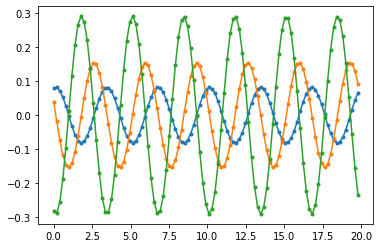

In [34]:
plt.figure()
plt.plot(wec.time, pos_td, '.-')
plt.plot(wec.time, vel_td, '.-')
plt.plot(wec.time, acc_td, '.-')